In [4]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

In [5]:
import sys, os
import numpy as np
import scipy
from scipy import stats
from sklearn import decomposition

In [3]:
scipy.__version__

'1.1.0'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
#MSX_ITERS = 10
TOL = 1.0e-8

In [6]:
video0 = mpe.VideoFileClip("campus_raw.AVI")
video = video0.subclip(t_start=(0, 0), t_end=(1, 53))

In [7]:
video.subclip(t_start=(0, 30), t_end=(1, 20)  ).ipython_display(width=500)

t:   0%|          | 2/500 [00:00<00:25, 19.66it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [8]:
video.duration, video.size

(113, (352, 288))

In [9]:
def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        frame = clip.get_frame(i/float(k))
        frame = rgb2gray(frame).astype(int)
        frame = scipy.misc.imresize(frame, scale).flatten()
        frames.append(frame)
    return np.vstack(frames).T

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [11]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [12]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

In [13]:
scale = 50   # Adjust scale to change resolution of image
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))
dims

(144, 176)

In [14]:
fps = 100
M = create_data_matrix_from_video(video, fps, scale)
# M = np.load("high_res_surveillance_matrix.npy")
M.shape, dims

((25344, 11300), (144, 176))

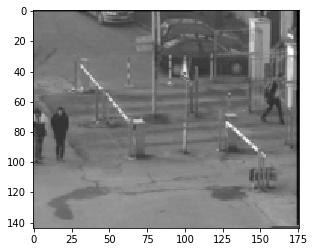

In [15]:
plt.imshow(np.reshape(M[:,3700], dims), cmap='gray');

In [16]:
np.save("low_res_surveillance_matrix.npy", M) #you have slow pre-processing steps, 
                                             #it's a good idea to save the results for future use.

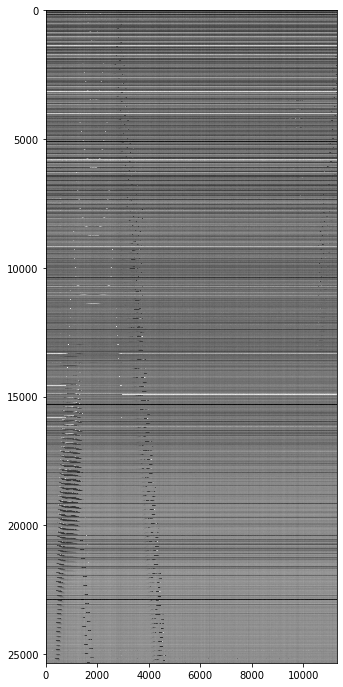

In [17]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [18]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,3700], dims), cmap='gray')

In [22]:
# this takes a while...
random_columns = np.random.randint(0, M.shape[1], 1000)
background = stats.mode(M[:, random_columns], axis=1).mode
np.save('background', background)
background.shape

(25344, 1)

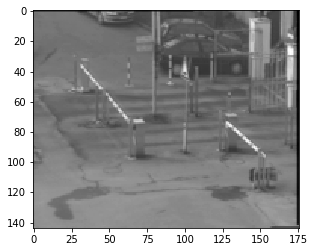

In [23]:

plt.imshow(background.reshape(dims), cmap='gray');

In [24]:
people = M - background
people.shape

(25344, 11300)

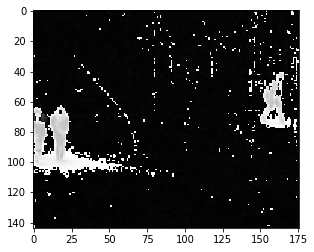

In [25]:
plt.imshow(people[:,3700].reshape(dims), cmap='gray');

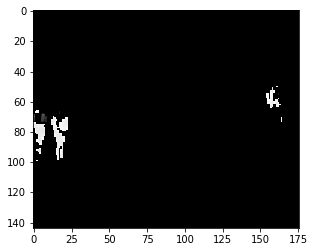

In [26]:
people[(people < 25) | (people > 210)] = 0
plt.imshow(people[:,3700].reshape(dims), cmap='gray');

In [ ]:
# this takes a while...
U, s, Vh = decomposition.randomized_svd(M, 2)
U.shape, s.shape, Vh.shape
np.savez('svd_components', U, s, Vh)        # applying SVD for foreground

In [ ]:
# this takes a while...
low_rank_M = U @ np.diag(s) @ Vh
np.save('data/low_rank_video_matrix', low_rank_M)
low_rank_M.shape

In [ ]:
people = M - low_rank_M

## Video

In [ ]:

# this takes a while
people_frames = people.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('data/people.mp4', fps=fps)

## SVD

In [20]:
from sklearn import decomposition

In [ ]:
u, s, v = decomposition.randomized_svd(M, 2)

In [ ]:
u.shape, s.shape, v.shape

In [35]:
low_rank = u @ np.diag(s) @ v

In [36]:
low_rank.shape

(6336, 11300)

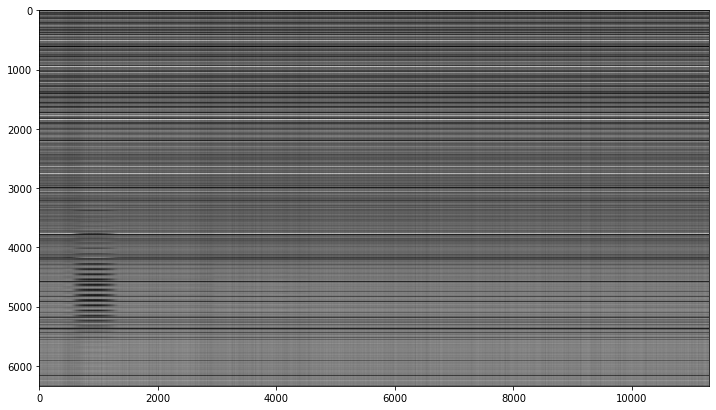

In [37]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

In [ ]:
plt.imshow(np.reshape(low_rank[:,3700], dims), cmap='gray');